## Interface to statsmodels: state space time series models

This notebook provides a short exposition of how it is possible to interface with the cornucopia of time series models provided by the [statsmodels](https://www.statsmodels.org/stable/index.html) package. In this notebook, we illustrate how to fit the logistic ODE model, where the errors are described by state space models.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Fitting a local level state space model

We assume that the observed data $y(t)$ follows

$$y(t)= f(t; \theta) + \epsilon(t),$$

where $f(t; \theta)$ is the [logistic model](../toy/model-logistic.ipynb) solution. The errors are assumed to follow a local level model:

$$\epsilon(t) = \mu(t) + \nu(t),$$
$$\mu(t) = \mu(t-1) + \eta(t),$$

as described [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents) (also see this link for a description of the huge family of state space models available in this package). Here, $\nu(t) \sim \mathcal{N}(0, \sigma_\nu)$ and $\eta(t) \sim \mathcal{N}(0, \sigma_\eta)$.

The two parameters of the error process are the variances: $\sigma_\nu^2$ and $\sigma_\eta^2$.

In [2]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

We first generate some local level noise and overlay on the ODE. Note that this noise is non-stationary, so the observed data can drift away from the actual solution for long periods.

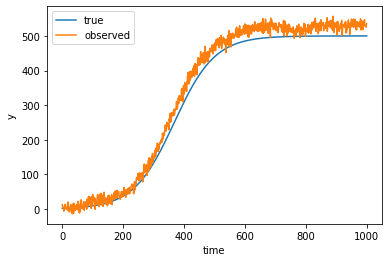

In [3]:
import scipy.stats

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# function to generate local level errors
def local_level(n, sigma_nu, sigma_eta):
    nu = scipy.stats.norm.rvs(0, sigma_nu, n)
    eta = scipy.stats.norm.rvs(0, sigma_eta, n)
    epsilon = np.zeros(n)
    mu = np.zeros(n)
    mu[0] = eta[0]
    for i in range(1, n):
        mu[i] = mu[i - 1] + eta[i]
    for i in range(n):
        epsilon[i] = mu[i] + nu[i]
    return epsilon

sigma_nu = 10
sigma_eta = 1
errors = local_level(len(org_values), sigma_nu, sigma_eta)
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

Note, that when wrapping the various models in this package into Pints, a useful function is the `model.param_names` function that provides a description of these parameters. We illustrate this below: note that `beta.x1` is the coefficient on the ODE solution, so needs to be supplied as '1' in the wrapper we show later.

In [4]:
sol = model.simulate([0.15, 500], times)
model = UnobservedComponents(endog=values, level='llevel', exog=sol)
model.param_names

['sigma2.irregular', 'sigma2.level', 'beta.x1']

Wrapping the a state space model in a Pints log-likelihood. Here, `ss_model` is a string corresponding to the list of prebuilt state space models [here](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html#statsmodels.tsa.statespace.structural.UnobservedComponents); `ss_n_params` is the number of parameters that the particular time series model involves.

In [5]:
class StateSpaceLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, problem, ss_model, ss_n_params):
        super(StateSpaceLogLikelihood, self).__init__(problem)
        self._nt = len(self._times) - 1
        self._no = problem.n_outputs()
        self._ss_model = ss_model
        self._ss_n_params = ss_n_params
        self._n_parameters = problem.n_parameters() + ss_n_params * self._no
    
    def __call__(self, x):
        # converting to list makes it easier to append
        # nuisance params
        x = x.tolist()
        m = self._ss_n_params * self._no
        
        # extract noise model params
        parameters = x[-m:]
        sol = self._problem.evaluate(x[:-m])
        model = UnobservedComponents(endog=problem.values(),
                                     level=self._ss_model, exog=sol)
        
        # add nuisance parameter at end: the coefficient
        # on the ODE model solution (which should be 1)
        return model.loglike(parameters + [1])

Instantiate the model, log-posterior etc., then run MCMC.

In [6]:
model = toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = StateSpaceLogLikelihood(problem, 'llevel', 2)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.00, 400, 0, 0],
    [0.05, 600, 3000, 3000],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array([0.015, 500] + [sigma_nu**2, sigma_eta**2])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


Show traces.

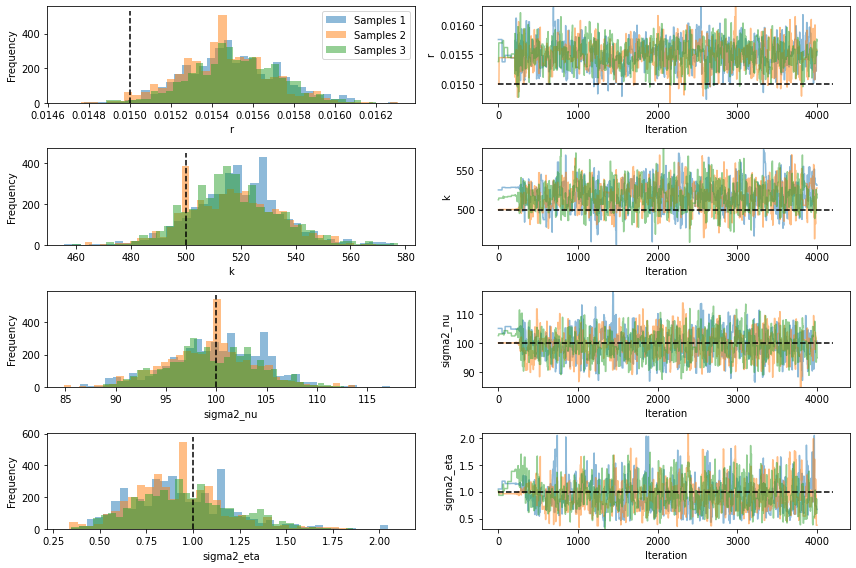

In [7]:
pints.plot.trace(chains,
                 parameter_names=['r', 'k', 'sigma2_nu', 'sigma2_eta'],
                 ref_parameters=real_parameters)
plt.show()

Look at summary stats: all parameters look similar to their true values.

In [8]:
results = pints.MCMCSummary(chains=chains, 
                            parameter_names=['r', 'k', 'sigma2_nu', 'sigma2_eta'])
print(results)

param       mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess
----------  ------  ------  ------  ------  ------  ------  -------  ------  ------
r           0.02    0.00    0.02    0.02    0.02    0.02    0.02     1.01    729.45
k           517.67  16.41   487.18  506.08  517.09  528.18  551.86   1.01    726.92
sigma2_nu   99.62   4.51    90.67   96.72   99.75   102.74  108.21   1.00    423.16
sigma2_eta  0.94    0.26    0.49    0.75    0.92    1.09    1.51     1.01    543.61
